In [1]:
%matplotlib inline
from astropy.cosmology import LambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
import astropy.units as u
from scipy.integrate import quad
import ezgal # BC03 model maker
import os

# Setup Cosmology

In [2]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)

# Create Stellar Population

In [3]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

model = ezgal.model('bc03_ssp_z_0.02_salp.model')
model = model.make_exponential(1)
model.set_cosmology(Om=cosmo.Om0, Ol=cosmo.Ode0, h=cosmo.h, w=cosmo.w(0))
                                   
model.add_filter('g_MOSAICII.res', name='g')
model.add_filter('r_MOSAICII.res', name='r')
model.add_filter('i_MOSAICII.res', name='i')
model.add_filter('z_MOSAICII.res', name='z')
model.add_filter('K_KittPeak.res', name='K')

# Blanton 2003 Normalization
Mr_star = -20.44 + 5 * np.log10(cosmo.h) # abs mag.
# set the normalization
model.set_normalization('sloan_r', 0.1, Mr_star, vega=False)                                   

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


# Calculate a few things to get going.

In [4]:
# desired formation redshift
zf = 6.0
# fetch an array of redshifts out to given formation redshift
zs = model.get_zs(zf)

# Calculate some cosmological stuff
DM = cosmo.distmod(zs)
dlum = cosmo.luminosity_distance(zs)

# Define the functions that we'll need

Need to compute the cluster volume...

$M_{vir} = 4/3 \pi r^3_{vir} \rho_c(r<r_{vir}) = 4/3 \pi r^3_{vir} \Delta_c \rho_c$

if we let $\Delta_c = 200$ then 

$M_{200} = 4/3 \pi r^3_{200} 200 \rho_c$ with $\rho_c = \frac{3H(z)^2}{8\pi G}$

or just $M_{200} = V_{200}200\rho_c$. So we'll make a function to calculate $\rho_c$. And we'll make use of the astropy units package to do all the unit analysis for us.

Don't forget that $H(z) = H_0E(z)$ 

## We also need to integrate the Schechter luminosity functions..

The Schechter Function:

For Luminosity:

$\Phi(L) = \phi^\star \frac{L}{L_\star}^\alpha e^{-\frac{L}{L_\star}}$

For Magnitudes:

$\Phi(M) = \phi^\star\frac{2}{5}log(10) (10^{\frac{2}{5}(M_\star - M)})^{\alpha+1} e^{-10^{\frac{2}{5}(M_\star - M)}}$




In [5]:
def rho_crit(z, cosmo):
    # convert G into better units:
    G = const.G.to(u.km**2 * u.Mpc/(u.M_sun * u.s**2))
    return 3 / (8 * np.pi * G) * cosmo.H0**2 * cosmo.efunc(z)**2 # Mpc^3

def schechterL(luminosity, phiStar, alpha, LStar): 
    """Schechter luminosity function.""" 
    LOverLStar = (luminosity/LStar) 
    return (phiStar/LStar) * LOverLStar**alpha * np.exp(- LOverLStar) 

def schechterM(magnitude, phiStar, alpha, MStar): 
    """Schechter luminosity function by magnitudes.""" 
    MStarMinM = 0.4 * (MStar - magnitude) 
    return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

# Start Calculating things

In [6]:
# So now we are going to calculate the volumes as a function of z
M200 = 1e15 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# calculate the abs mag of our limiting magnitude as a function of z
mlim = 21.2
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

/home/boada/.local/lib/python3.6/site-packages/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


# Integrate

In [7]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    y, err = quad(schechterM, -np.inf, M_lim, args=(phi, a, M_star))
    LF.append(y)

/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


# Plot

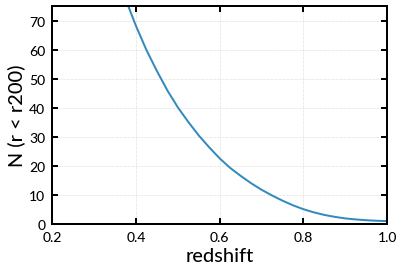

In [8]:
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 1)
plt.ylim(0, 75)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

# Add clusters from the Hennig paper.

In [9]:
import pandas as pd
df = pd.read_csv('../hennig/tbl.tex', sep='&', header=None, engine='python', comment='%', dtype='object')
for i in range(len(df.columns)):
    df[i] = df[i].map(lambda x: x.replace('$', ''))
    df[i] = df[i].map(lambda x: x.strip())

df.columns = ['Cluster', 'M200', 'z', 'cg', 'N200', 'cg,rs', 'N200,rs', 'cg,nrs', 'N200,nrs']
for c in df.columns:                                                             
    df.loc[df.loc[:, c].str.strip() == "-", c] = np.nan

for i in range(1, 2*len(df.columns), 2 ):
    try:
        df.insert(i+1, f'{df.columns[i]}_err', np.nan)
    except IndexError:
        pass    
    
df = df.astype('object')
for i, row in df.iterrows():
    for j in range(1, len(df.columns), 2):
        col = df.columns[j]
        col_err = df.columns[j + 1]
        try:
            # the error array is [plus, minus]
            df.at[i, col_err] = [float(row[col].split('^')[1][2:7].rstrip('}')), 
                                 abs(float(row[col].split('^')[1][10:].rstrip('}')))]
            df.at[i, col] = float(row[col].split('^')[0])
        except IndexError:
            df.at[i, col_err] = float(row[col].split('\pm')[-1])
            df.at[i, col] = float(row[col].split('\pm')[0])
        except AttributeError:
            continue

In [10]:
### recalculate things ###
##########################

# So now we are going to calculate the volumes as a function of z
M200 = 6e14 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# The Hennig paper gives their depths in table 2. 
# I am just going to do everything in the i band.

# calculate the abs mag of our limiting magnitude as a function of z
mlim = model.get_apparent_mags(zf, filters='i', zs=zs) + 2
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

Mlim = model.get_absolute_mags(zf, filters='i', zs=zs) + 2

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

In [11]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    y, err = quad(schechterM, -np.inf, M_lim, args=(phi, a, M_star))
    LF.append(y)

/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing imports until


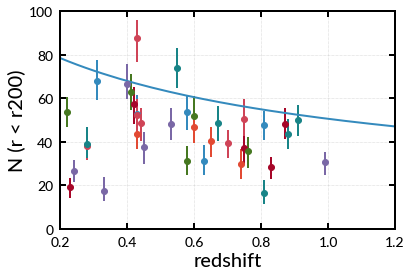

In [12]:
# plot the model
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
#ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 1.2)
plt.ylim(0, 100)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

# add the clusters

for i, row in df.iterrows():
    if (row.M200 + row.M200_err[0] > 6) and (6 > row.M200 - row.M200_err[1]):
        if np.isnan(row['N200,rs']):
            continue
        plt.errorbar(row.z, row['N200,rs'], yerr=np.array(row['N200,rs_err'][::-1])[:, np.newaxis], fmt='o')


# Test Area Below...

/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


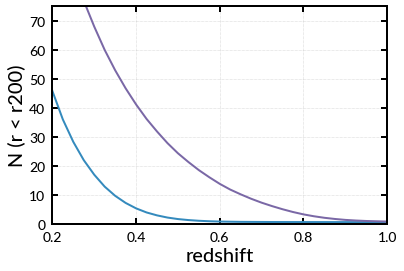

In [13]:
# calculate the abs mag of our limiting magnitude as a function of z
mlim_arr = [19.5, 21.2]
for mlim in mlim_arr:
    Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

    # Calculate the M_star values
    Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

    # Here are the Schechter function stuff from Liu et al.
    phi_star = 3.6 * cosmo.efunc(zs)**2
    alpha = -1.05 * (1 + zs)**(-2/3)
    fr = 0.8*(1 + zs)**(-1/2)

    LF = []
    for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
        y, err = quad(schechterM, -np.inf, M_lim, args=(phi, a, M_star))
        LF.append(y)
        
    plt.plot(zs, (LF * V200.value + 1) * fr)

ax = plt.gca()
ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 1)
plt.ylim(0, 75)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

In [14]:
df

,Cluster,M200,M200_err,z,z_err,cg,cg_err,N200,N200_err,"cg,rs","cg,rs_err","N200,rs","N200,rs_err","cg,nrs","cg,nrs_err","N200,nrs","N200,nrs_err"
0,SPT-CL J0001-5440,6.3,"[1.5, 1.9]",0.89,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SPT-CL J0008-5318,5.2,"[1.3, 1.8]",0.39,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SPT-CL J0012-5352,5.9,"[1.4, 2.0]",0.4,0.02,5.77,"[2.18, 1.46]",82.4,"[11.5, 11.5]",7.75,"[2.9, 1.98]",66.7,"[9.19, 7.21]",2.88,"[4.11, 1.73]",13.2,"[4.17, 8.11]"
3,SPT-CL J0036-4411,6.1,"[1.4, 1.8]",0.87,0.01,5.74,"[2.59, 2.06]",85.2,"[13.5, 12.1]",10.73,"[5.65, 3.36]",48.2,"[7.36, 7.06]",NaN,NaN,NaN,NaN
4,SPT-CL J0040-4407,17.5,"[2.9, 3.9]",0.39,0.01,3.34,"[1.03, 0.89]",233.3,"[22.3, 18.4]",5.45,"[1.55, 1.3]",169.8,"[14.1, 14.8]",NaN,NaN,NaN,NaN
5,SPT-CL J0041-4428,10.2,"[1.7, 2.4]",0.36,0.02,1.15,"[0.73, 0.52]",143.5,"[9.71, 16.4]",1.94,"[0.69, 0.51]",123.4,"[9.65, 11.2]",NaN,NaN,NaN,NaN
6,SPT-CL J0102-4915,25.7,"[4.7, 5.8]",0.88,0.03,2.37,"[0.88, 0.73]",223.8,"[21.5, 19.5]",6.01,"[2.07, 1.48]",108.7,"[10.2, 11.3]",NaN,NaN,NaN,NaN
7,SPT-CL J0107-4855,5.3,"[1.2, 1.9]",0.6,0.02,13.97,"[10.6, 5.12]",36.2,"[9.79, 10.9]",10.76,"[5.42, 3.3]",52,"[9.04, 8.18]",NaN,NaN,NaN,NaN
8,SPT-CL J0330-5228,11.7,"[1.9, 2.7]",0.45,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SPT-CL J0412-5106,6.1,"[1.4, 1.9]",0.28,0.03,1.25,"[0.72, 0.55]",73.3,"[11.2, 10.6]",6.35,"[3.92, 2.44]",38.2,"[6.6, 6.4]",NaN,NaN,NaN,NaN
